最佳 x = [3.4221646900626164]
最佳 f(x) = -0.8077088100110321


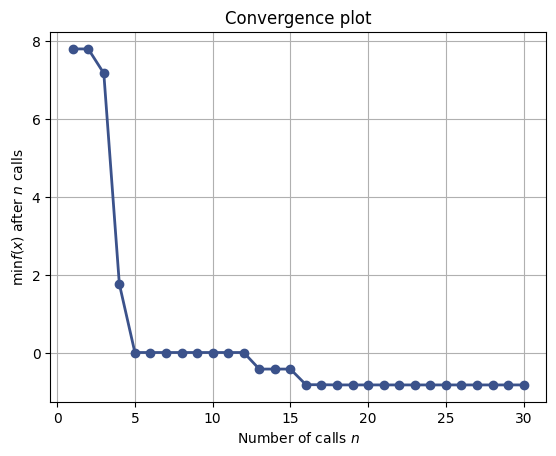

In [4]:
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
import numpy as np
import matplotlib.pyplot as plt

# 目標函數（黑箱）
def f(x):
    return (x[0] - 3)**2 + np.sin(5 * x[0])

# 搜尋範圍
space = [(-2.0, 8.0)]

# Bayesian Optimization
res = gp_minimize(
    f,
    space,
    n_calls=30,
    random_state=42,
    acq_func="EI"  # Expected Improvement
)

print("最佳 x =", res.x)
print("最佳 f(x) =", res.fun)

# 收斂圖
plot_convergence(res)
plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
model = RandomForestClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, None]
}

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X, y)

print("最佳參數 = ", grid.best_params_)

最佳參數 =  {'max_depth': 5, 'n_estimators': 50}


In [7]:
!pip install optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 12)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    scores = cross_val_score(clf, X, y, cv=5)
    return -scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("最佳參數:", study.best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.1 MB/s eta 0:00:00


[I 2025-11-16 15:09:11,361] A new study created in memory with name: no-name-e783e7b6-8919-4c65-a8e8-cab9ba651b36
[I 2025-11-16 15:09:11,739] Trial 0 finished with value: -0.9666666666666668 and parameters: {'n_estimators': 69, 'max_depth': 6}. Best is trial 0 with value: -0.9666666666666668.
[I 2025-11-16 15:09:13,074] Trial 1 finished with value: -0.96 and parameters: {'n_estimators': 267, 'max_depth': 12}. Best is trial 0 with value: -0.9666666666666668.
[I 2025-11-16 15:09:13,838] Trial 2 finished with value: -0.9533333333333334 and parameters: {'n_estimators': 149, 'max_depth': 7}. Best is trial 0 with value: -0.9666666666666668.
[I 2025-11-16 15:09:14,985] Trial 3 finished with value: -0.96 and parameters: {'n_estimators': 230, 'max_depth': 5}. Best is trial 0 with value: -0.9666666666666668.
[I 2025-11-16 15:09:16,473] Trial 4 finished with value: -0.96 and parameters: {'n_estimators': 297, 'max_depth': 4}. Best is trial 0 with value: -0.9666666666666668.
[I 2025-11-16 15:09:18,

最佳參數: {'n_estimators': 69, 'max_depth': 6}


In [8]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 1),
    "max_depth": hp.quniform("max_depth", 2, 12, 1)
}

def objective(params):
    clf = RandomForestClassifier(
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"])
    )
    score = cross_val_score(clf, X, y, cv=5).mean()
    return -score

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print("最佳參數:", best)

100%|██████████| 50/50 [00:48<00:00,  1.03trial/s, best loss: -0.9666666666666668]
最佳參數: {'max_depth': np.float64(11.0), 'n_estimators': np.float64(147.0)}


In [9]:
import time
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Optuna
import optuna

# Hyperopt
from hyperopt import fmin, tpe, hp, Trials

# Skopt
from skopt import gp_minimize
from skopt.space import Integer

X, y = load_iris(return_X_y=True)

def evaluate_model(clf):
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

results = {}

# ------------------------------------------------
# 1. Grid Search
# ------------------------------------------------
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 4, 6],
}

start = time.time()
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X, y)
results["grid"] = {
    "best_params": grid.best_params_,
    "best_score": grid.best_score_,
    "time": time.time() - start
}

# ------------------------------------------------
# 2. Random Search
# ------------------------------------------------
param_dist = {
    "n_estimators": np.arange(50, 300),
    "max_depth": np.arange(2, 12),
}

start = time.time()
rand = RandomizedSearchCV(
    clf, param_dist, n_iter=30, cv=5, random_state=42
)
rand.fit(X, y)
results["random"] = {
    "best_params": rand.best_params_,
    "best_score": rand.best_score_,
    "time": time.time() - start
}

# ------------------------------------------------
# 3. Optuna (TPE)
# ------------------------------------------------
def optuna_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 12)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    return -evaluate_model(model)

start = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(optuna_objective, n_trials=30)
results["optuna"] = {
    "best_params": study.best_params,
    "best_score": -study.best_value,
    "time": time.time() - start
}

# ------------------------------------------------
# 4. Hyperopt (TPE)
# ------------------------------------------------
space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 1),
    "max_depth": hp.quniform("max_depth", 2, 12, 1),
}

def hyperopt_objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"])
    )
    return -evaluate_model(model)

start = time.time()
trials = Trials()
best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)
results["hyperopt"] = {
    "best_params": best,
    "best_score": -min(trials.losses()),
    "time": time.time() - start
}

# ------------------------------------------------
# 5. Skopt Bayesian Optimization (GP)
# ------------------------------------------------
space_skopt = [
    Integer(50, 300),
    Integer(2, 12),
]

def skopt_objective(params):
    n_estimators, max_depth = params
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    return -evaluate_model(model)

start = time.time()
res = gp_minimize(
    skopt_objective,
    space_skopt,
    n_calls=30,
    random_state=42
)
results["skopt"] = {
    "best_params": {"n_estimators": res.x[0], "max_depth": res.x[1]},
    "best_score": -res.fun,
    "time": time.time() - start
}

# ------------------------------------------------
# 最終結果輸出
# ------------------------------------------------
for method, r in results.items():
    print(f"=== {method.upper()} ===")
    print("最佳參數:", r["best_params"])
    print("最佳分數:", r["best_score"])
    print("花費時間:", r["time"])
    print()

[I 2025-11-16 15:15:19,399] A new study created in memory with name: no-name-059f5ba5-02c2-4496-9bfa-df78be247adc
[I 2025-11-16 15:15:20,855] Trial 0 finished with value: -0.96 and parameters: {'n_estimators': 281, 'max_depth': 11}. Best is trial 0 with value: -0.96.
[I 2025-11-16 15:15:21,798] Trial 1 finished with value: -0.96 and parameters: {'n_estimators': 185, 'max_depth': 5}. Best is trial 0 with value: -0.96.
[I 2025-11-16 15:15:23,243] Trial 2 finished with value: -0.9666666666666668 and parameters: {'n_estimators': 283, 'max_depth': 6}. Best is trial 2 with value: -0.9666666666666668.
[I 2025-11-16 15:15:24,060] Trial 3 finished with value: -0.9600000000000002 and parameters: {'n_estimators': 142, 'max_depth': 11}. Best is trial 2 with value: -0.9666666666666668.
[I 2025-11-16 15:15:24,893] Trial 4 finished with value: -0.9666666666666668 and parameters: {'n_estimators': 112, 'max_depth': 3}. Best is trial 2 with value: -0.9666666666666668.
[I 2025-11-16 15:15:25,391] Trial 5

100%|██████████| 30/30 [00:28<00:00,  1.06trial/s, best loss: -0.9666666666666668]


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(300), np.int64(10)] before, using random point [np.int64(231), np.int64(10)]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(299), np.int64(12)] before, using random point [np.int64(88), np.int64(7)]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(300), np.int64(11)] before, using random point [np.int64(233), np.int64(11)]
  warnings.warn(


=== GRID ===
最佳參數: {'max_depth': 4, 'n_estimators': 100}
最佳分數: 0.9666666666666668
花費時間: 8.337725400924683

=== RANDOM ===
最佳參數: {'n_estimators': np.int64(164), 'max_depth': np.int64(6)}
最佳分數: 0.9666666666666668
花費時間: 29.73718547821045

=== OPTUNA ===
最佳參數: {'n_estimators': 283, 'max_depth': 6}
最佳分數: 0.9666666666666668
花費時間: 29.859228134155273

=== HYPEROPT ===
最佳參數: {'max_depth': np.float64(7.0), 'n_estimators': np.float64(235.0)}
最佳分數: 0.9666666666666668
花費時間: 28.245274543762207

=== SKOPT ===
最佳參數: {'n_estimators': np.int64(165), 'max_depth': np.int64(5)}
最佳分數: 0.9666666666666668
花費時間: 34.63130307197571

